# Introduction

This notebook implement a Deep Recurrent Q-learning Network for automated stock trading as presented in:  
- L. Chen and Q. Gao, "Application of Deep Reinforcement Learning on Automated Stock Trading," 2019.  
https://ieeexplore-ieee-org.ezproxy.universite-paris-saclay.fr/document/9040728 

# Imports

In [1]:
import sys
sys.path.append("./src")

In [2]:
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Data

[*********************100%%**********************]  1 of 1 completed


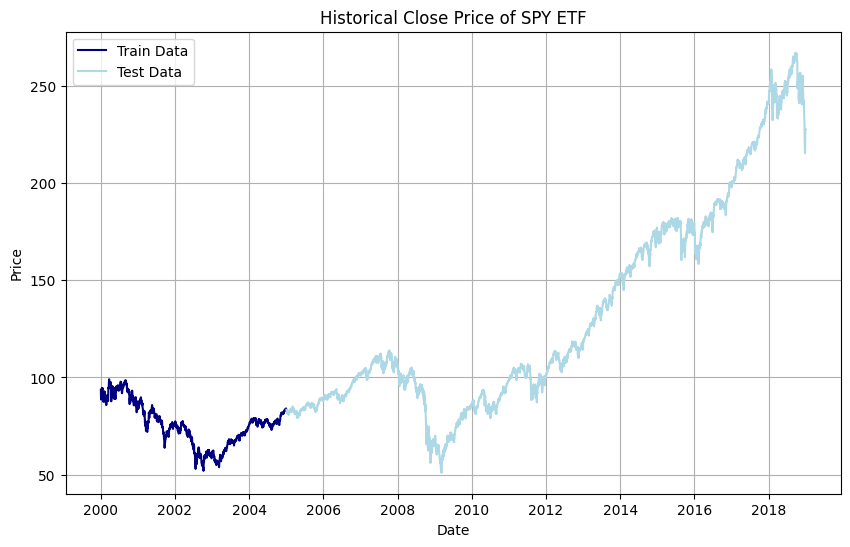

In [3]:
ticker_symbol = 'SPY'

spy_data = yf.download(ticker_symbol, start='2000-01-01', end='2018-12-31')
spy_data

train_data = spy_data[spy_data.index < "2005-01-01"]
test_data = spy_data[spy_data.index >= "2005-01-01"]

train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Data', color='navy')
plt.plot(test_data.index, test_data, label='Test Data', color='lightblue')
plt.title('Historical Close Price of SPY ETF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
train_data

Date
2000-01-03    93.591148
2000-01-04    89.931152
2000-01-05    90.092033
2000-01-06    88.644119
2000-01-07    93.792259
                ...    
2004-12-27    83.516815
2004-12-28    83.974159
2004-12-29    84.098930
2004-12-30    83.939529
2004-12-31    83.759346
Name: Adj Close, Length: 1256, dtype: float64

# Environment

In [5]:
import numpy as np
import random

import gymnasium as gym
from gymnasium import spaces


class TradingEnv(gym.Env):
    def __init__(self, data, state_dim=20):
        """
        Initialize the trading environment
        """
        super(TradingEnv, self).__init__()

        self.data = data

        self.current_step = None
        self.state = None
        self.cumulative_reward = None

        self.action_space = spaces.Discrete(3)
        self.action_dic = {0: -1, 1: 0, 2: 1}  # sell  # hold  # buy

        self.observation_space = spaces.Box(
            low=np.array([0] * state_dim),
            high=np.array([np.inf] * state_dim),
            dtype=np.float32,
        )

        self.action_dim = self.action_space.n
        self.state_dim = self.observation_space.shape[0]

        self.reset()

    def reset(self):
        """
        Reset the trading environment
        """
        self.current_step = 0
        self.state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]
        self.cumulative_reward = 0
        self.done = False

        return self.state

    def compute_reward(self, state, new_state, action):
        """
        Calculate the reward based on the change in balance, position, and trading action.
        """
        price = state.iloc[-1]
        new_price = new_state.iloc[-1]
        reward = (new_price - price) * action
        return reward

    def is_done(self):
        if self.state_dim + self.current_step == len(self.data):
            return True
        else:
            return False

    def step(self, action):
        """
        Take a step in the trading environment
        """
        self.current_step += 1

        # State
        state = self.state

        # New state
        new_state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]

        # Reward
        reward = self.compute_reward(state, new_state, self.action_dic[action])
        self.cumulative_reward += reward

        # Done
        self.done = self.is_done()

        # Info
        self.info = {
            "step": self.current_step,
            "price": state.iloc[-1],
            "action": self.action_dic[action],
            "new_price": new_state.iloc[-1],
            "reward": self.cumulative_reward,
            "done": self.done,
        }

        self.state = new_state

        return self.state, reward, self.done, self.info

    def render(self):
        """
        Print the current state
        """
        print(f"current step: {self.current_step}")
        print(f"state: {self.state}")
        print(f"state shape: {self.state.shape}")

    def run_backtest(self, policy):
        """
        Run a full backtest of the trading environment using the provided policy.
        The policy function should take a state as input and return an action.
        """
        self.reset()
        history = []
        while not self.done:
            action = policy(self.state)
            self.step(action)
            history.append(self.info)
        return history

In [6]:
toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
toy_env.step(2)
state_2 = toy_env.state
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * 1

toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
toy_env.step(0)
state_2 = toy_env.state
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * -1

toy_env = TradingEnv(train_data, 20)
state_1 = toy_env.state
toy_env.step(1)
state_2 = toy_env.state
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * 0


# Models

In [7]:
# class DQN(nn.Module):
#     def __init__(self, input_size, output_size, hidden_dims):
#         super(DQN, self).__init__()
#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(input_size, hidden_dims[0])
#         ])
#         for i in range(len(hidden_dims) - 1):
#             self.hidden_layers.extend([
#                 nn.Linear(hidden_dims[i], hidden_dims[i+1]) 
#             ])
#         self.output_layer = nn.Linear(hidden_dims[-1], output_size)

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = F.relu(layer(x))
#         x = self.output_layer(x)
#         return x
    
    

### DRQN

In [88]:
# class DRQN(nn.Module):
#     def __init__(self, input_size, output_size, hidden_dims, rnn_units):
#         super(DRQN, self).__init__()

#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(input_size, hidden_dims[0])
#         ])
#         for i in range(len(hidden_dims) - 1):
#             self.hidden_layers.extend([
#                 nn.Linear(hidden_dims[i], hidden_dims[i+1]) 
#             ])
#         self.rnn = nn.RNN(hidden_dims[-1], rnn_units, batch_first=True)
#         self.fc = nn.Linear(rnn_units, output_size)

#     def forward(self, x):
#         """
#         x.shape: (batch_size, seq_length, input_size)
#         h_0.shape: (num_layers, batch_size, rnn_units)
#         """
#         if len(x.shape) == 2: # (batch_size, seq_length)
#             x = x.unsqueeze(1)
#         batch_size = x.size(0)

#         for layer in self.hidden_layers:
#             x = F.relu(layer(x))
        
#         h_0 = torch.zeros(1, batch_size, self.rnn.hidden_size)
#         out, _ = self.rnn(x, h_0)
#         out = self.fc(out)
#         out = out.squeeze(1)
#         return out
    
class DRQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims, rnn_units):
        super(DRQN, self).__init__()

        self.rnn = nn.RNN(input_size, rnn_units, batch_first=True)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(rnn_units, hidden_dims[0])
        ])
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i+1]) 
            ])
        self.fc = nn.Linear(hidden_dims[-1], output_size)

    def forward(self, x):
        """
        x.shape: (batch_size, seq_length, input_size)
        h_0.shape: (num_layers, batch_size, rnn_units)
        """
        if len(x.shape) == 2: # (batch_size, seq_length)
            x = x.unsqueeze(1)
        batch_size = x.size(0)
        
        h_0 = torch.zeros(1, batch_size, self.rnn.hidden_size)
        x, _ = self.rnn(x, h_0)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.fc(x)
        x = x.squeeze(1)
        return x

# Replay memory - all good

In [89]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.memory)


# Train

### Greedy action

In [90]:
def update_epsilon(epsilon, decay_rate, min_epsilon):
    epsilon *= decay_rate
    epsilon = max(epsilon, min_epsilon)
    return epsilon

def record_explore_exploit(func):

    def wrapper(env, policy, state, epsilon):
        random_sample = np.random.rand()
        wrapper.epsilon_list.append(epsilon)
        if random_sample < epsilon:
            wrapper.action_list.append(0) 
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            wrapper.action_list.append(1) 
            return func(policy, state)

    wrapper.action_list = []
    wrapper.epsilon_list = []

    def reset_lists():
        wrapper.action_list = []
        wrapper.epsilon_list = []

    wrapper.reset_lists = reset_lists

    return wrapper

@record_explore_exploit
def epsilon_greedy_action(policy, state):
    with torch.no_grad():
        return policy(state).max(1).indices.view(1, 1)
    
    
# eps_test = EPS_START
# eps_tests = []

# for i in range(1000):
#     eps_test = update_epsilon(eps_test, EPS_DECAY, EPS_MIN)
#     eps_tests.append(eps_test)
#     if eps_test == 0.01:
#         print(i)
#         break

# eps_tests


### Parameters

The deep Q-network contains 4 layers and the number of 
units for each layer is 20,10,10 and 3 respectively. We use ReLU 
as the activation function. The learning rate is set to be 
exponential decayed every 100 steps on the training dataset and 
the initial rate is 0.001, while on the test dataset, the learning rate 
is set as a fixed value 0.001. For the Q-learning part, the discount 
factor is set to y = 0.79, this value is quite small because the 
problem we defined is a short-term daily trading process so that 
we pay more attention to current reward. The max $\epsilon$ is set to 
0.99 and start with 0. The batch size is set to 100 and the 
parameters for target network $\widetilde{Q}$ is replaced every 100 
iterations. As for the DRQN model, the time step is set to 20, 
and the number of RNN units is set to 6 .

In [91]:
NUM_EPISODE = 10 # from paper

HIDDEN_DIMS = [20, 10, 10] # from paper

LR_DECAY_FREQ = 100 # from paper
LR = 0.001 # from paper
TEST_LR = 0.001 # from paper
LR_DECAY = 0.9

DISCOUNT_FACTOR = 0.79 # from paper

EPS_MIN = 0.01 # from paper
EPS_START = 1.0 # from paper
EPS_DECAY = 0.9995

BATCH_SIZE = 100 # from paper
MEMORY_SIZE = 10000

TARGET_UPDATE_FREQUENCY = 100 # from paper

LSTM_TIME_STEP = 20 # from paper
NUM_RNN_UNITS = 6 # from paper

ENV_STATE_DEPTH = 20

### Train loop

In [92]:
def train(env, model, target_model, replay_memory, optimizer, scheduler, criterion):

    model.train()

    total_rewards = []
    history = []
    logs = {"action": [], "epsilon": [], "learning_rate": []}
    wrapper_actions = []
    wrapper_epsilons = []

    total_step_count = 0
    epsilon = EPS_START

    for episode in tqdm(range(NUM_EPISODE)):
        epoch_total_rewards = [0]

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
            0
        )

        while not env.done:
            total_step_count += 1

            logs["epsilon"].append(epsilon)
            action = epsilon_greedy_action(env, model, state, epsilon)
            logs["action"].append(action.item())
            epsilon = update_epsilon(epsilon, EPS_DECAY, EPS_MIN)

            next_state, reward, done, _ = env.step(action.item())
            epoch_total_rewards.append(epoch_total_rewards[-1] + reward)

            next_state = torch.tensor(
                next_state, dtype=torch.float32, device=device
            ).unsqueeze(0)
            reward = torch.tensor([reward], device=device)
            replay_memory.push(state, action, reward, next_state, done)

            state = next_state

            if len(replay_memory) > BATCH_SIZE:
                
                states, actions, rewards, next_states, dones = replay_memory.sample(
                    BATCH_SIZE
                )
                states = torch.tensor(states, dtype=torch.float32).squeeze(1)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                states = states.squeeze(1)
                next_states = states.squeeze(1)
                actions = actions.unsqueeze(1)

                # print(f"states shape: {states.shape}")
                # print(f"actions shape: {actions.shape}")
                # print(f"rewards shape: {rewards.shape}")
                # print(f"next states shape: {next_states.shape}")

                state_action_values = model(states).gather(1, actions)
                next_state_values = target_model(next_states).max(1)[0].detach()
                expected_state_action_values = (
                    rewards + (1 - dones) * DISCOUNT_FACTOR * next_state_values
                )

                loss = criterion(
                    state_action_values, expected_state_action_values.unsqueeze(1)
                )

                logs["learning_rate"].append(optimizer.param_groups[0]["lr"])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (
                    total_step_count > BATCH_SIZE
                    and total_step_count % LR_DECAY_FREQ == 0
                ):
                    scheduler.step()

            if total_step_count % TARGET_UPDATE_FREQUENCY == 0:
                target_model.load_state_dict(model.state_dict())

        total_rewards.append(epoch_total_rewards)
        history.append(env.info)
        wrapper_epsilons.append(epsilon_greedy_action.epsilon_list)
        wrapper_actions.append(epsilon_greedy_action.action_list)

        epsilon_greedy_action.reset_lists()

    return total_rewards, history, logs, wrapper_epsilons, wrapper_actions

In [93]:
train_env = TradingEnv(train_data, state_dim=ENV_STATE_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn.load_state_dict(drqn.state_dict())
target_drqn.eval()

replay_memory = ReplayMemory(MEMORY_SIZE)

drqn_optimizer = torch.optim.SGD(drqn.parameters(), lr=LR)
lr_scheduler = ExponentialLR(drqn_optimizer, gamma=LR_DECAY)

criterion = nn.MSELoss()

train_total_rewards, train_history, train_logs, wrapper_epsilons, wrapper_actions  = train(
    train_env, 
    model=drqn,
    target_model=target_drqn,
    replay_memory=replay_memory,
    optimizer=drqn_optimizer,
    scheduler=lr_scheduler,
    criterion=criterion
)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\alexa\AppData\Local\Temp\ipykernel_18496\3963134610.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
C:\Users\alexa\AppData\Local\Temp\ipykernel_18496\3963134610.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_state = torch.tensor(
100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


### Epsilon

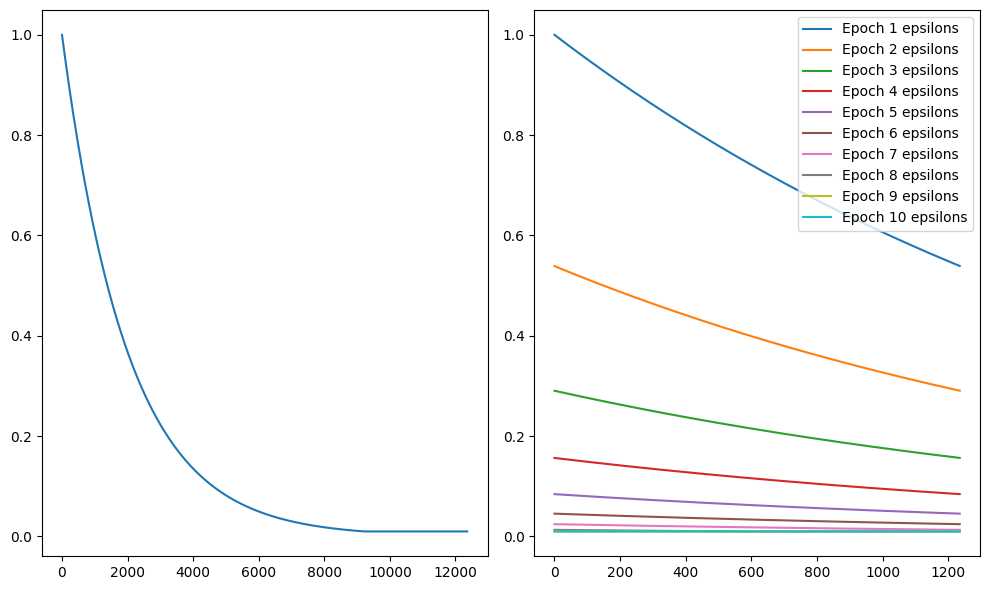

In [94]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(train_logs["epsilon"], label="Epsilons")

plt.subplot(1, 2, 2)
for i, epsilons in enumerate(wrapper_epsilons):
    plt.plot(epsilons, label=f"Epoch {i+1} epsilons")

plt.tight_layout()
plt.legend()
plt.show()


### Exploration / Exploitation

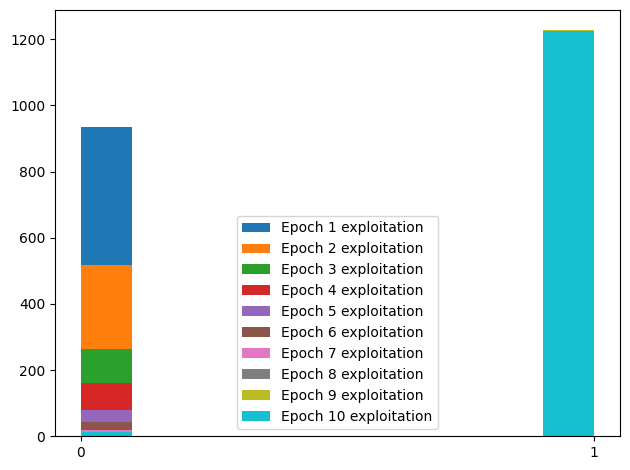

In [95]:
for i, actions in enumerate(wrapper_actions):
    plt.hist(actions, label=f"Epoch {i+1} exploitation")

plt.xticks([0, 1])
plt.tight_layout()
plt.legend()
plt.show()

### Learning rates

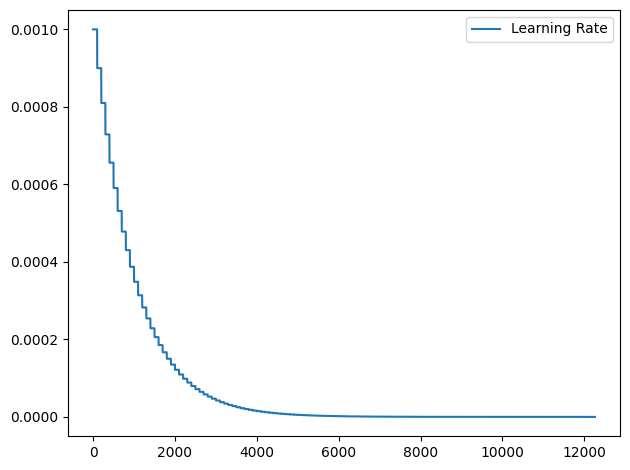

In [96]:
plt.plot(train_logs["learning_rate"], label="Learning Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Actions

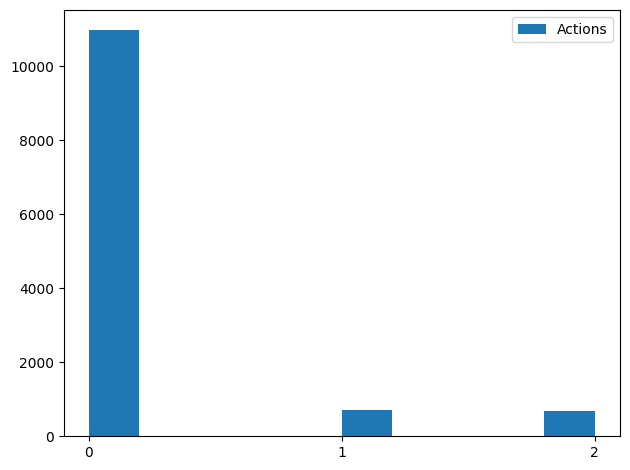

In [97]:
plt.hist(train_logs["action"], label="Actions")
plt.xticks([0, 1, 2])
plt.tight_layout()
plt.legend()
plt.show()

### Rewards

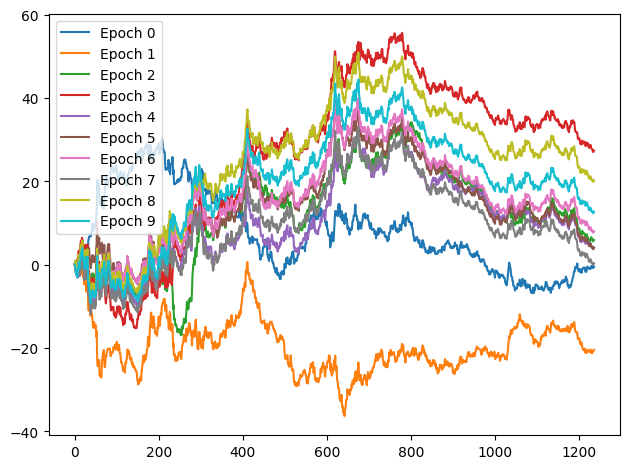

In [98]:
for i, epoch_rewards in enumerate(train_total_rewards):
    plt.plot(epoch_rewards, label=f"Epoch {i}")
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
[elem["reward"] for elem in train_history]

[-0.5028457641601562,
 -20.45562744140625,
 5.907203674316406,
 27.359588623046875,
 4.122417449951172,
 4.022308349609375,
 7.993061065673828,
 0.2815704345703125,
 20.18752670288086,
 12.653961181640625]

### Data

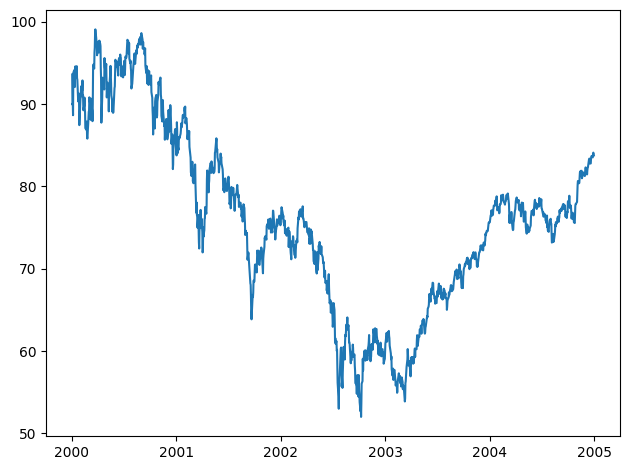

In [100]:
plt.plot(train_data)
plt.tight_layout()
plt.show()

# Eval

In [101]:
def eval(env, model):

    model.eval()

    # total_rewards = [0]
    history = []

    total_step_count = 0

    state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
        0
    )

    while not env.done:
        total_step_count += 1

        action = epsilon_greedy_action(env, model, state, 0)
        next_state, reward, _, _ = env.step(action.item())
        
        next_state = torch.tensor(
            next_state, dtype=torch.float32, device=device
        ).unsqueeze(0)
        reward = torch.tensor([reward], device=device)

        state = next_state

        # total_rewards.append(total_rewards[-1] + reward.item())
        history.append(env.info)

    return history

In [102]:
test_env = TradingEnv(test_data, state_dim=ENV_STATE_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n


test_history  = eval(
    test_env, 
    model=target_drqn
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_18496\1812277358.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
C:\Users\alexa\AppData\Local\Temp\ipykernel_18496\1812277358.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_state = torch.tensor(


In [103]:
test_history_df = pd.DataFrame(test_history)
test_history_df

,step,price,action,new_price,reward,done
0,1,81.881424,-1,82.401154,-0.519730,False
1,2,82.401154,-1,82.650581,-0.769157,False
2,3,82.650581,-1,82.435760,-0.554337,False
3,4,82.435760,-1,83.315849,-1.434425,False
4,5,83.315849,-1,83.204971,-1.323547,False
...,...,...,...,...,...,...
3497,3498,225.759644,-1,221.133942,-139.252518,False
3498,3499,221.133942,-1,215.290939,-133.409515,False
3499,3500,215.290939,-1,226.168472,-144.287048,False
3500,3501,226.168472,-1,227.904877,-146.023453,False


### Rewards

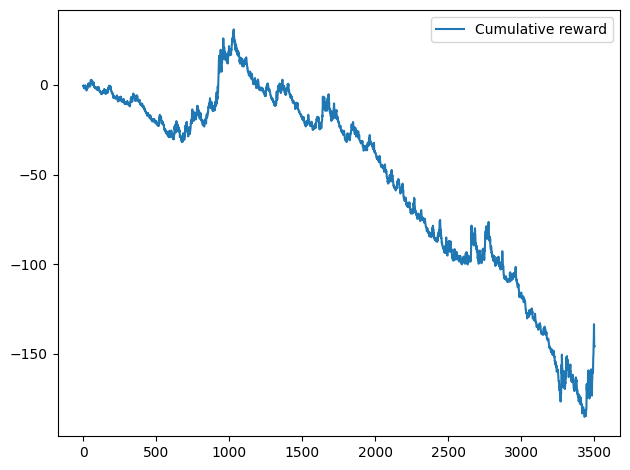

In [105]:
plt.plot([info["reward"] for info in test_history], label="Cumulative reward")
plt.legend()
plt.tight_layout()
plt.show()

### Data

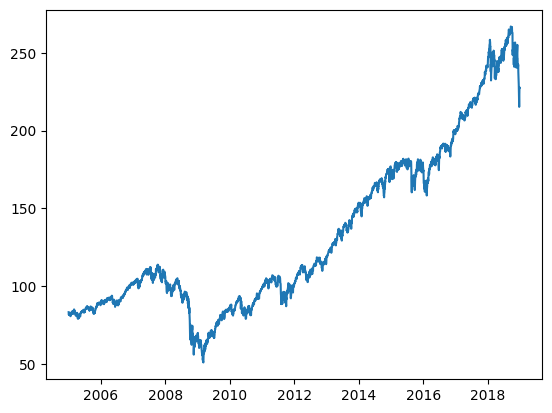

In [106]:
plt.plot(test_data)
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_18496\2720831429.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_signals.append(prices[i])


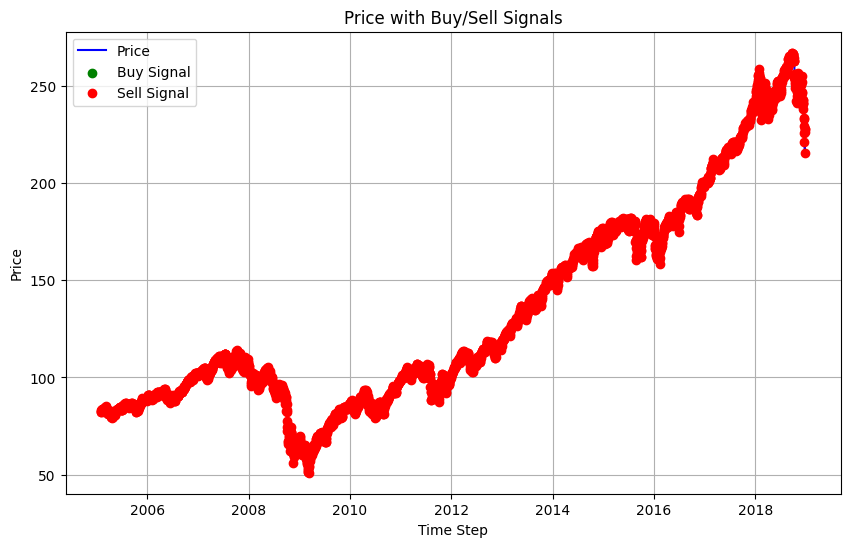

In [107]:
def visualize(prices, actions):
    buy_signals = []
    sell_signals = []

    for i in range(len(prices)):
        if actions[i] == 1:
            buy_signals.append(prices[i])
            sell_signals.append(None)
        elif actions[i] == -1:
            buy_signals.append(None)
            sell_signals.append(prices[i])
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    plt.figure(figsize=(10, 6))
    plt.plot(prices, color='blue', label='Price')
    plt.scatter(prices.index, buy_signals, color='green', label='Buy Signal', zorder=5)
    plt.scatter(prices.index, sell_signals, color='red', label='Sell Signal', zorder=5)
    plt.title('Price with Buy/Sell Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize(test_data.iloc[20:], test_history_df.action)

In [268]:
len(test_data)
len([0] *20 + [info["action"] for info in test_history])

3522

# Test

In [157]:
env_test = TradingEnv(test_data, 20)

def test(env, model, num_episode):

    model.eval()

    rewards = []

    for _ in tqdm(range(num_episode)):
        epoch_rewards =[0]

        state = torch\
            .tensor(env.reset(), dtype=torch.float32, device=device) \
            .unsqueeze(0)

        while not env.done:
            action = model(state).max(1).indices.view(1, 1)
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch \
                .tensor(next_state, dtype=torch.float32, device=device) \
                .unsqueeze(0)
            
            epoch_rewards.append(epoch_rewards[-1] + reward)
            
            state = next_state
            if done: break    
    
        rewards.append(epoch_rewards)

    return rewards

rewards = test(
    TradingEnv(test_data, 20),
    model=target_drqn,
    num_episode=10
)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\alexa\AppData\Local\Temp\ipykernel_11032\159439412.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .tensor(env.reset(), dtype=torch.float32, device=device) \
C:\Users\alexa\AppData\Local\Temp\ipykernel_11032\159439412.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .tensor(next_state, dtype=torch.float32, device=device) \
100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


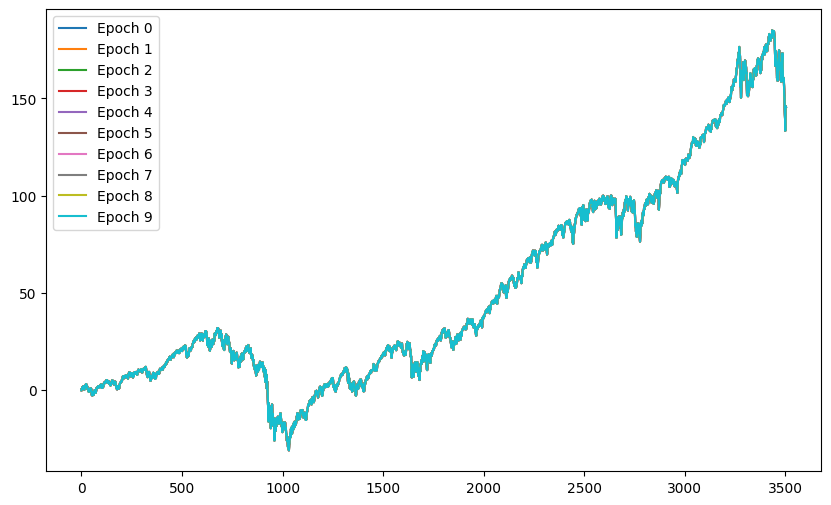

In [160]:
plt.figure(figsize=(10, 6))
for i, epoch_rewards in enumerate(rewards):
    plt.plot(epoch_rewards, label=f"Epoch {i}")
plt.legend()
plt.show()

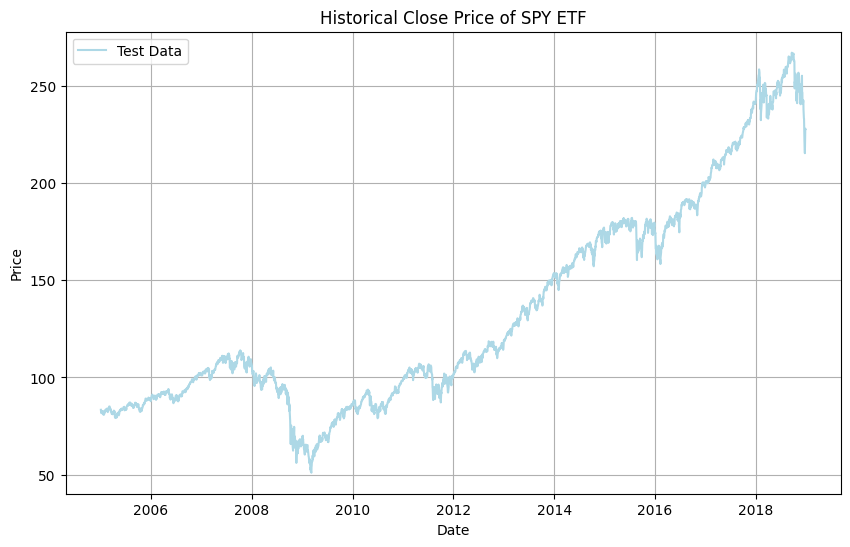

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Test Data', color='lightblue')
plt.title('Historical Close Price of SPY ETF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()